### Installing required libraries
( if it is not already installed )


In [1]:
 # !pip install numpy
 # !pip install pandas
 # !pip install matplotlib
 # !pip install seaborn
 # !pip install pillow
 # !pip install torch
 # !pip install torchvision
 # !pip install scikit-learn

### Importing required libraries


In [34]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader, Dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [7]:
#constants and configuration 
#here cuda is for nvidia GPU only
device="cuda" if  torch.cuda.is_available() else "cpu"

In [8]:
train_dir="mri_dataset/Training" # training directory
test_dir="mri_dataset/testing" # testing directory

categories=sorted(os.listdir(train_dir))
batch_size=64; #64

label_map={"glioma":0,
            "meningioma":1,
            "notumor":2,
           "pituitary":3
          }

class_dict={v: k for k, v in label_map.items()}

In [9]:
def count_images_per_class(directory):
    
    count={} # empty dictionary
    for name in os.listdir(directory):
        path=os.path.join(directory,name)
        if os.path.isdir(path):
            count[name]=len(os.listdir(path))
    return count

print("Training distionary:",count_images_per_class("mri_dataset/training"))
print("Testing distionary:",count_images_per_class("mri_dataset/testing"))


def show_pie_chart(count,title):

    labels=list(count.keys())
    sizes=list(count.values())
    plt.figure()
    plt.pie(sizes,labels=labels,autopct='%1.1f%%')
 
    plt.title(title)
    plt.show()

def plot_image_grid(images,titles=None,cols=3,figsize=None,cmap='gray'):



    n=len(images)
    rows=(n+cols-1)//cols

    if figsize is None: 
        figsize=(cols*4,rows*4)

    fig,axes=plt.subplots(rows,cols,figsize=figsize)
    axes=np.array(axes).reshape(-1)
    
    for i, ax in enumerate(axes):
        ax.axis('off')
        if i<n: 
            img=images[i]
            ax.imshow(img,cmap=cmap)
            if titles:
                ax.set_title(titles[i],fontsize=10)

    plt.tight_layout()
    plt.show()

def show_sample_images(directory,n):


    class_dirs=[]
    for d in os.listdir(directory):
        if os.path.isdir(os.path.join(directory,d)):
            class_dirs.append(d)

    samples=[]
    while len(samples) < n:
        cls=random.choice(class_dirs)
        files=os.listdir(os.path.join(directory,cls))
        fname=random.choice(files)
        samples.append((cls, os.path.join(directory,cls,fname)))


    images,titles = [],[]
    for cls ,path in samples:
        img = plt.imread(path)
        h,w = img.shape[:2]
        ch = img.shape[2] if img.ndim==3 else 1
        images.append(img)
        titles.append(f"{cls}\n{os.path.basename(path)}\n"
                      f"{h}x{w}px, ch={ch}")
    plot_image_grid(images,titles,cols=3)  

def show_tensor_batch(images,labels,class_names,cols=4):
    titles=[f"label:{class_names[int(lb1)]}" for lb1 in labels]
    plot_image_grid(images,titles,cols=cols)

def show_data_distribution(datasets_dir):
    global_counts={}
    for dataset in os.listdir(datasets_dir):
        dataset_path=datasets_dir+"/"+dataset
        count=count_images_per_class(dataset_path)
        show_pie_chart(count,f"Images per class in {dataset}")
        global_counts[dataset]=sum(count.values())
    show_pie_chart(global_counts, "Total images: Training vs Testing")


 

Training distionary: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Testing distionary: {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


Data distribution


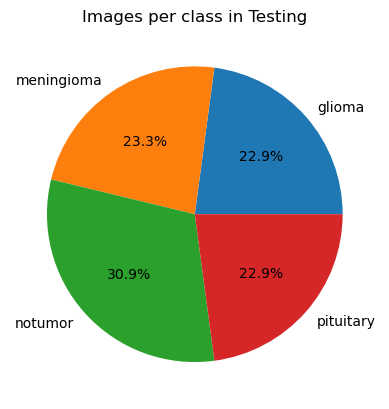

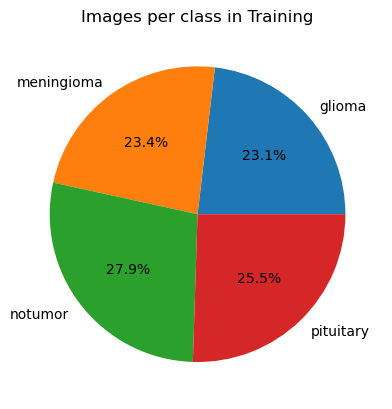

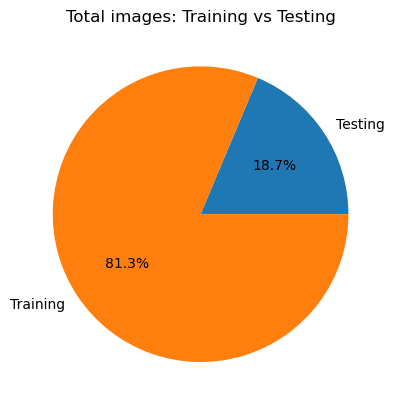

In [10]:
 print("Data distribution")
 show_data_distribution("mri_dataset")
 

Training sample images



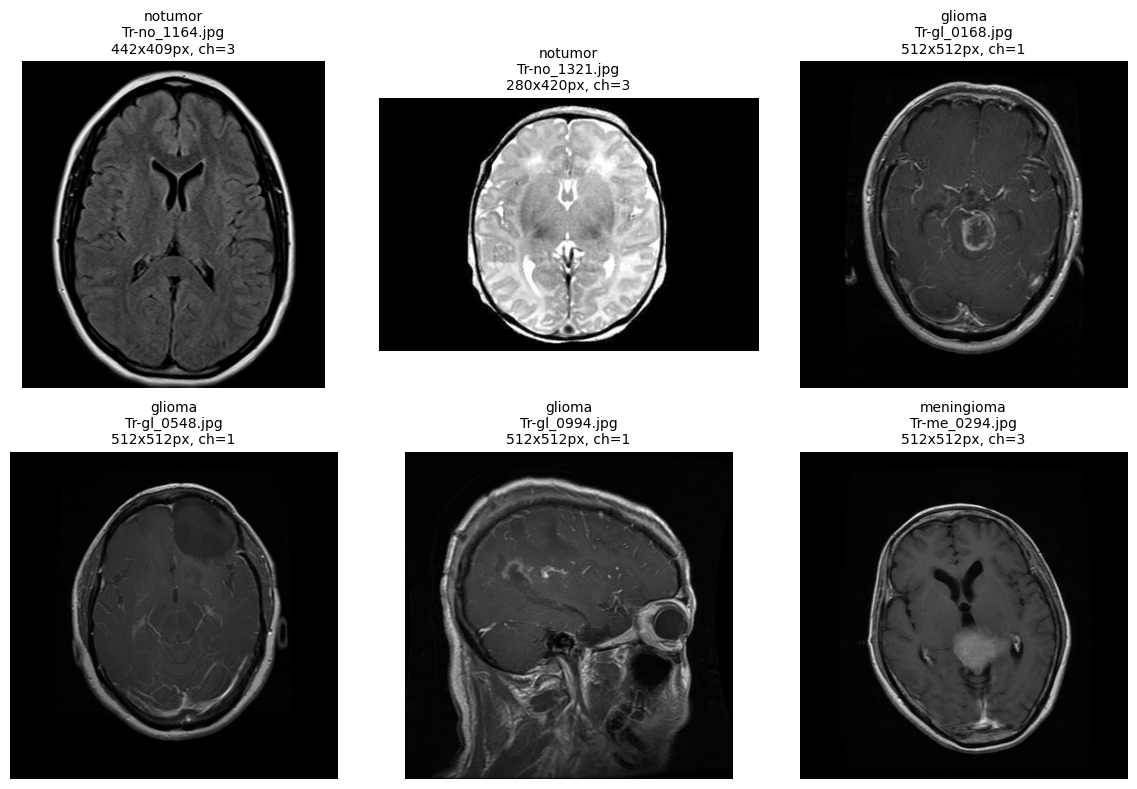


Testing sample images



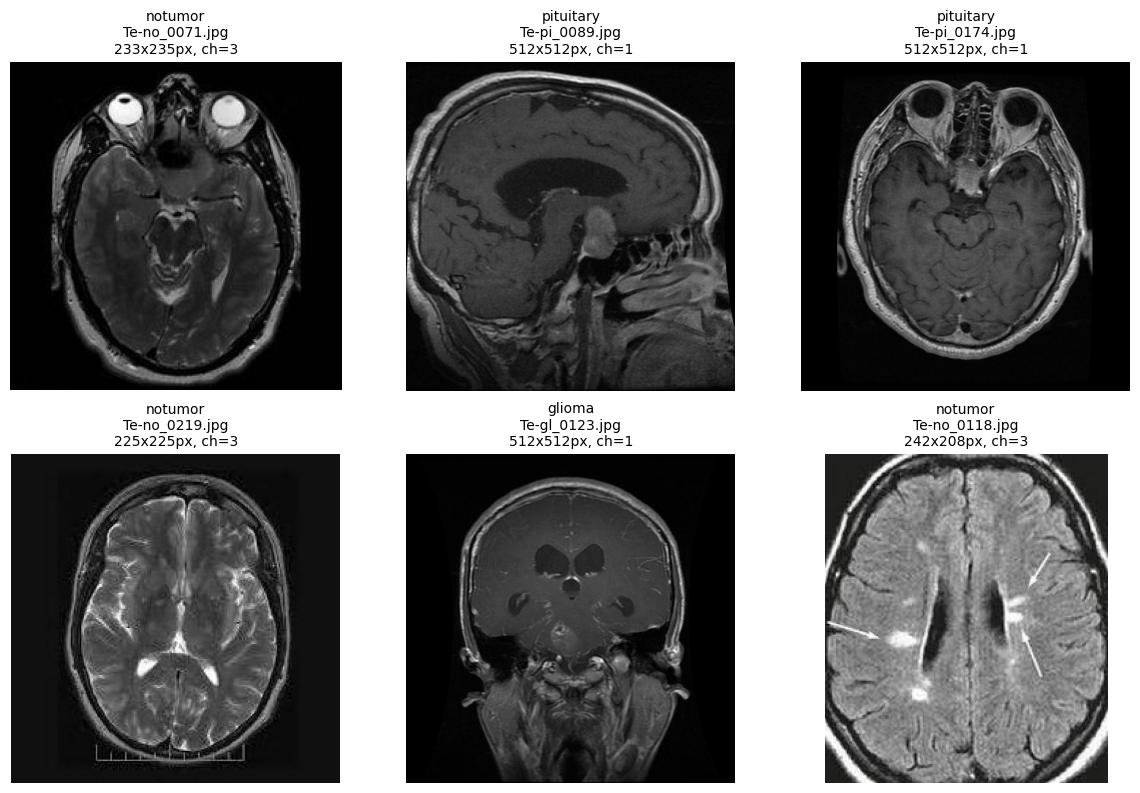

In [11]:
print("Training sample images\n")
show_sample_images(train_dir,n=6)
print("\nTesting sample images\n")
show_sample_images(test_dir,n=6)


In [12]:
simple_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
  ])


dataset=ImageFolder(train_dir,transform=simple_transform)

loader=DataLoader(dataset,batch_size=batch_size,shuffle=False)

mean=0.0
variance=0.0
total_images=0

for images, _ in loader:
    B,C,H,W=images.shape  # B = batch size, C=no. of channels, H=height, W= width
    images=images.view(B,C ,-1)
    batch_mean=images.mean(dim=2).sum(dim=0)
    batch_var=images.var(dim=2).sum(dim=0)
    mean+=batch_mean
    variance+=batch_var
    total_images+=B


mean/=total_images
std=(variance/total_images).sqrt()

mean=np.array(mean.tolist())
std=np.array(std.tolist())

print("Mean:",mean)
print("Standard Deviation:",std)

Mean: [0.18545197]
Standard Deviation: [0.1879696]


In [17]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(
        brightness=(0.8, 1.2),
        contrast=(0.8, 1.2),         
        saturation=(0.8, 1.2)        
    ),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)
])


all_train_datasets=ImageFolder(train_dir,transform=train_transform)

targets=np.array([label for _, label in all_train_datasets])

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state = 42)

for train_idx, val_idx in split.split(np.zeros(len(targets)),targets):
    train_dataset=Subset(all_train_datasets,train_idx)
    val_dataset= Subset(all_train_datasets,val_idx)

test_dataset=ImageFolder(test_dir,transform=test_transform)

#DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=1,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False,num_workers=1,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False,num_workers=1,pin_memory=True)

                               


D:\Anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


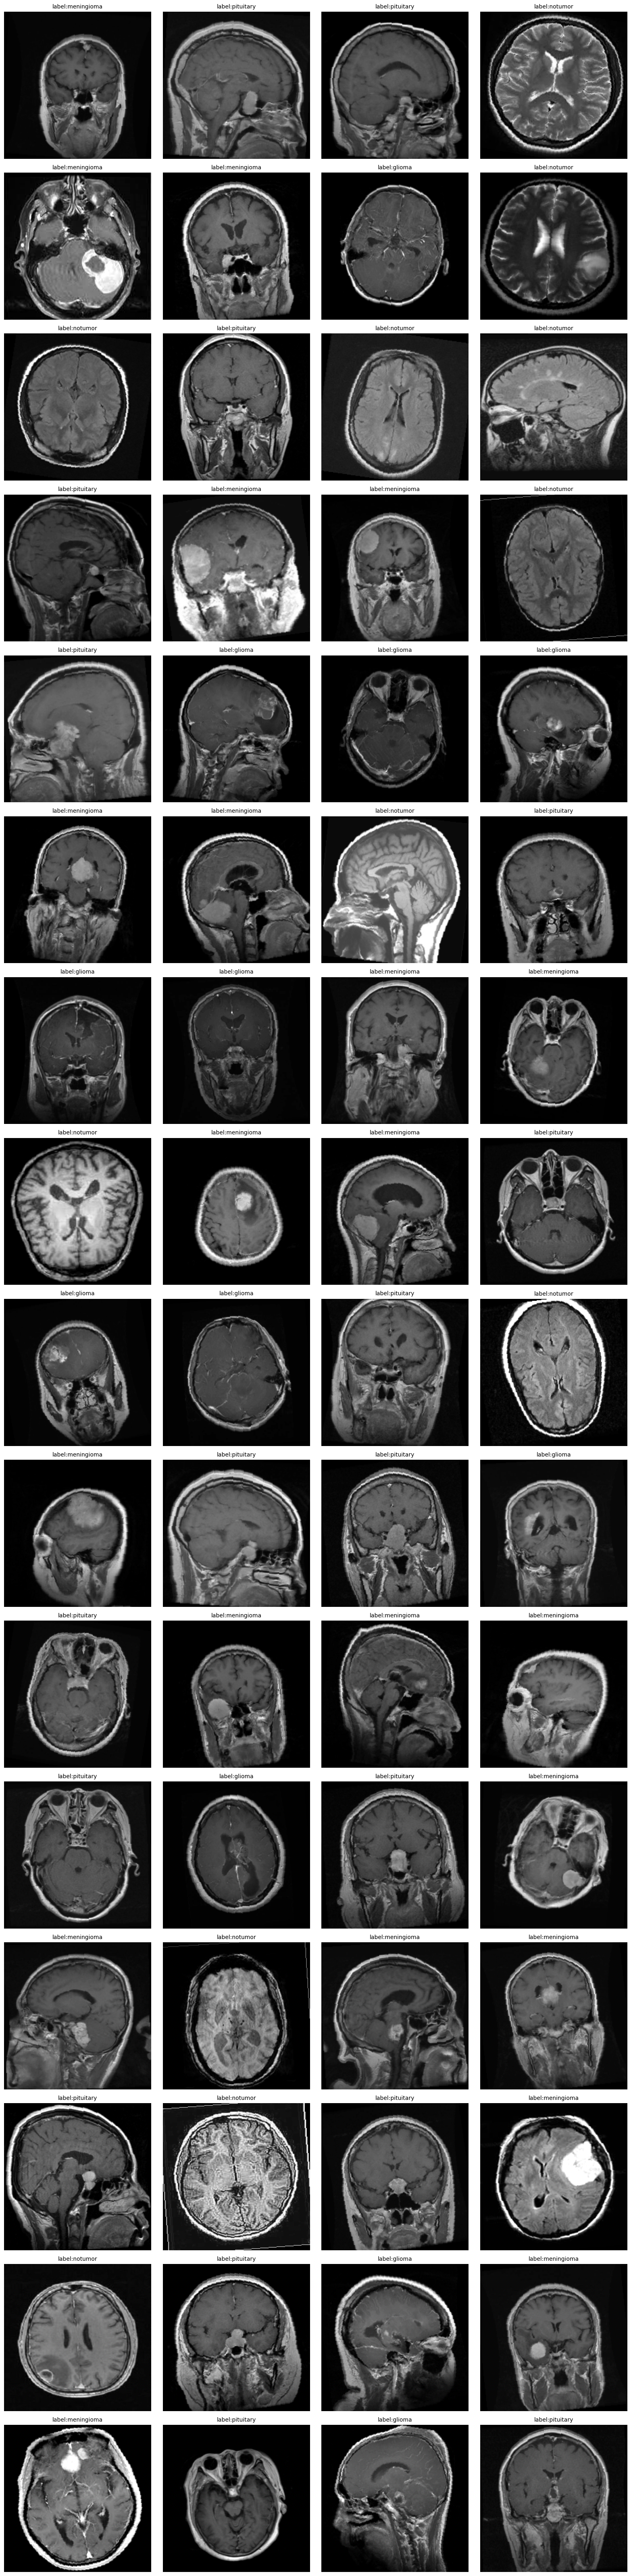

In [18]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Denormalize manually
images_np = images.clone().detach().numpy()
for i in range(images_np.shape[0]):
    images_np[i] = images_np[i] * std[:, None, None] + mean[:, None, None]

# Convert to (B, H, W, C)
images_np = images_np.transpose((0, 2, 3, 1)).clip(0, 1)

# Show images
show_tensor_batch(images_np, labels, categories, cols=4)


In [19]:


class BrainTumorClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorClassifier, self).__init__()

        self.features = nn.Sequential(
            # Input: 1 x 224 x 224
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32 x 112 x 112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 64 x 56 x 56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 128 x 28 x 28

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 256 x 14 x 14

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 256 x 7 x 7
        )

        self.fc = nn.Sequential(
            nn.Flatten(),                         # 256 * 7 * 7 = 12544
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)           # Output: num_classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.fc(x)
        return x


In [20]:
model = BrainTumorClassifier(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0007)


In [21]:
def train_model(model,train_loader,val_loader,criterion,optimizer,num_epochs,name="model", patience=2):
    device="cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    best_val_loss=float("inf")
    tolerance=0
    history={"train_loss":[],"train_acc":[],"val_loss":[],"val_acc":[]}

    for epoch in range(num_epochs):
        #Training stage
        model.train()
        running_loss=0.0
        correct_train=0
        total_train=0

        for images,labels in train_loader:
            images,labels=images.to(device),labels.to(device)
            optimizer.zero_grad()
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            _, predicted=torch.max(outputs,1)
            total_train+=labels.size(0)
            correct_train+=(predicted == labels).sum().item()


        train_loss=running_loss/len(train_loader)
        train_acc=100*correct_train/ total_train

        #Validation stage
        model.eval()
        val_loss=0.0
        correct_val=0
        total_val=0
        with torch.no_grad():
            for images,labels in val_loader: 
                images,labels=images.to(device),labels.to(device)
                outputs=model(images)
                loss=criterion(outputs,labels)
                val_loss+=loss.item()
                _, predicted= torch.max(outputs,1)
                total_val+=labels.size(0)
                correct_val+=(predicted==labels).sum().item()

        val_loss=val_loss / len(val_loader)
        val_acc=100*correct_val/total_val


        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss:{train_loss:.4f} | train accuracy:{train_acc:.3f}%")
        print(f"Val Loss:{val_loss:.4f} | Val Accuracy:{val_acc:.3f}%")
        print("-"*50)


        if val_loss<best_val_loss:
            best_val_loss= val_loss
            torch.save(model.state_dict(),f'best_brain_tumor_{name}.pth')
            tolerance=0

        
        else:
            tolerance+=1
            if tolerance >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    return history
    

In [22]:
print("start training........")
history=train_model(model,train_loader,val_loader,criterion,optimizer,num_epochs=10)


start training........

Epoch [1/10]
Train Loss:1.2548 | train accuracy:57.671%
Val Loss:1.0427 | Val Accuracy:58.268%
--------------------------------------------------

Epoch [2/10]
Train Loss:0.6405 | train accuracy:75.049%
Val Loss:0.6292 | Val Accuracy:74.628%
--------------------------------------------------

Epoch [3/10]
Train Loss:0.5429 | train accuracy:78.661%
Val Loss:0.4659 | Val Accuracy:80.577%
--------------------------------------------------

Epoch [4/10]
Train Loss:0.4463 | train accuracy:82.403%
Val Loss:0.6408 | Val Accuracy:73.403%
--------------------------------------------------

Epoch [5/10]
Train Loss:0.3819 | train accuracy:86.408%
Val Loss:0.3211 | Val Accuracy:88.801%
--------------------------------------------------

Epoch [6/10]
Train Loss:0.3378 | train accuracy:87.262%
Val Loss:0.5182 | Val Accuracy:79.703%
--------------------------------------------------

Epoch [7/10]
Train Loss:0.3345 | train accuracy:87.021%
Val Loss:0.3010 | Val Accuracy:88.189%

In [24]:
def plot_training_history(history,model_name="model"):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'],label='Train Loss')
    plt.plot(history['val_loss'],label='Val Loss')
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history["train_acc"],label="Train Acc")
    plt.plot(history["val_acc"],label="Val Acc")
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.show()
    

Graph View:


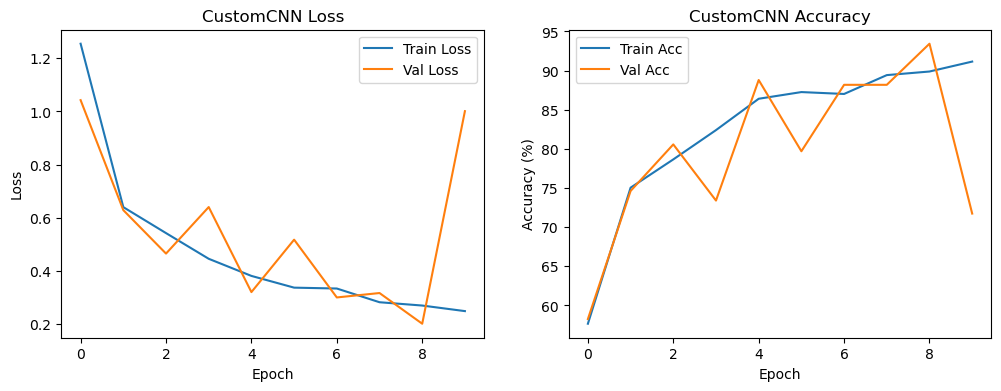

In [25]:
print("Graph View:")
plot_training_history(history,model_name="CustomCNN")

In [26]:
def plot_confusion_matrix(cm, categories, normalize=False, title='Confusion Matrix', cmap='Blues'):
    plt.figure(figsize=(8, 6))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
        
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=categories, yticklabels=categories)
    
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [27]:
def compute_confusion_details(cm, categories):
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (TP + FP + FN)

    print("\n" + "="*60)
    print("        Per-Class Metrics (TP, TN, FP, FN)")
    print("="*60)
    print(f"{'Class':<15} {'TP':>6} {'TN':>6} {'FP':>6} {'FN':>6}")
    print("-"*60)

    for i, cls in enumerate(categories):
        print(f"{cls:<15} {TP[i]:>6} {TN[i]:>6} {FP[i]:>6} {FN[i]:>6}")


In [30]:
def test_model(model, test_loader, num_images_to_show=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu().numpy())

    test_acc = 100 * correct / total
    print("\n" + "=" * 60)
    print(f"          Test Accuracy: {test_acc:.2f}%")
    print("=" * 60 + "\n")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, categories)
    compute_confusion_details(cm, categories)

    # Classification Report
    print("\n" + "=" * 60)
    print("             Classification Report")
    print("=" * 60)
    print(classification_report(all_labels, all_preds, target_names=categories))

    # Visualize Predictions
    if num_images_to_show > 0:
        sample_images = all_images[:num_images_to_show]
        sample_labels = all_labels[:num_images_to_show]
        sample_preds = all_preds[:num_images_to_show]

        titles = [
            f"True: {categories[true]}\nPred: {categories[pred]}"
            for true, pred in zip(sample_labels, sample_preds)
        ]

        # Convert to HWC format and de-normalize
        sample_images = np.array(sample_images)
        sample_images = sample_images * std.reshape(1, 1, 1) + mean.reshape(1, 1, 1)
        sample_images = sample_images.clip(0, 1)
        sample_images = sample_images.transpose(0, 2, 3, 1)

        show_tensor_batch(sample_images, sample_labels, categories, cols=4)



          Test Accuracy: 87.95%



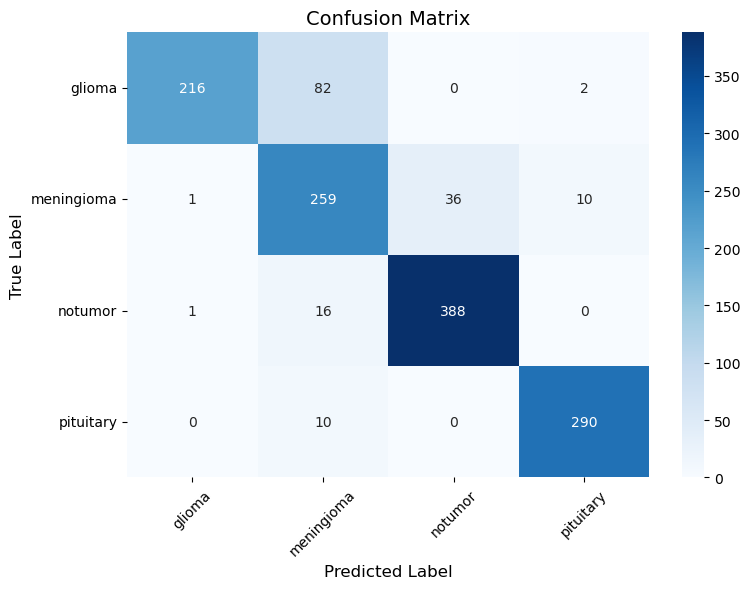


        Per-Class Metrics (TP, TN, FP, FN)
Class               TP     TN     FP     FN
------------------------------------------------------------
glioma             216   1009      2     84
meningioma         259    897    108     47
notumor            388    870     36     17
pituitary          290    999     12     10

             Classification Report
              precision    recall  f1-score   support

      glioma       0.99      0.72      0.83       300
  meningioma       0.71      0.85      0.77       306
     notumor       0.92      0.96      0.94       405
   pituitary       0.96      0.97      0.96       300

    accuracy                           0.88      1311
   macro avg       0.89      0.87      0.88      1311
weighted avg       0.89      0.88      0.88      1311



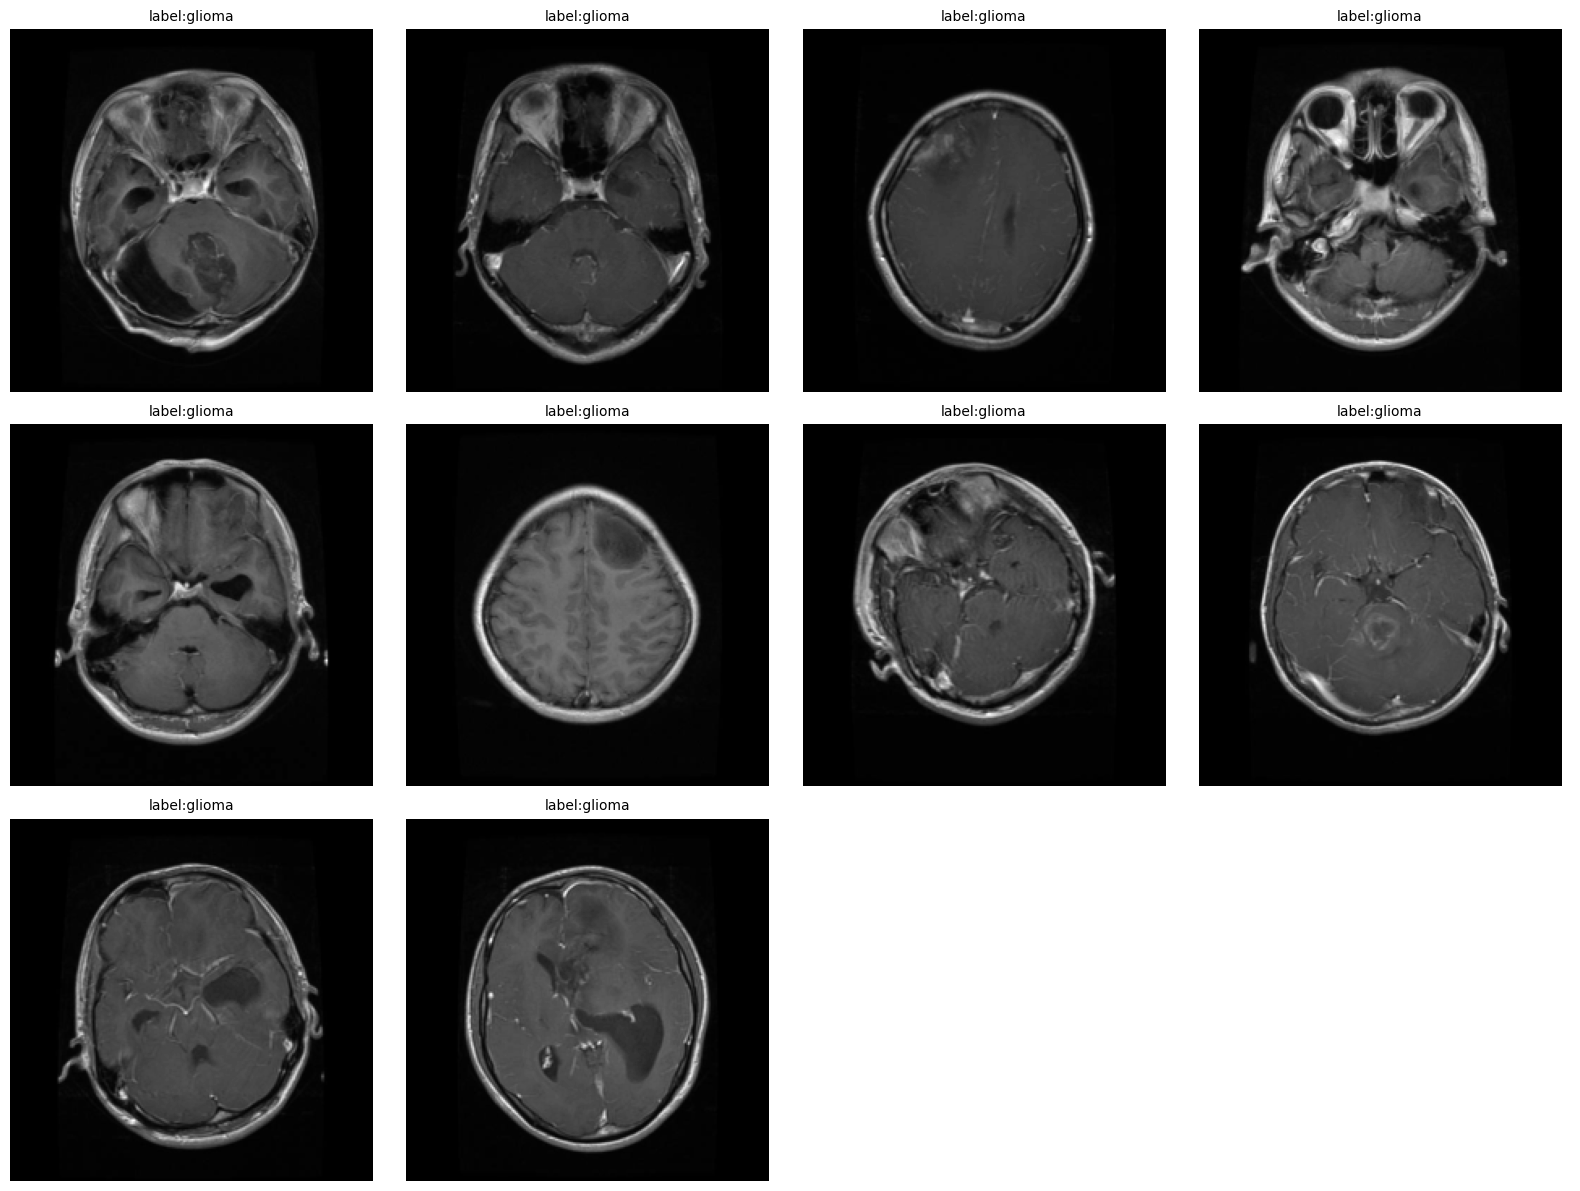

In [42]:
# Load the best model (make sure the path is correct and matches the saved filename)
model.load_state_dict(torch.load("best_brain_tumor_model.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))

# Evaluate on test data
test_model(model, test_loader)


In [43]:


def plot_model_predictions_topk(model, data_loader, num_samples=5, top_k=3):
    model.to(device).eval()

    correct_imgs, incorrect_imgs = [], []
    correct_titles, incorrect_titles = [], []

    with torch.no_grad():
        for imgs, lbls in data_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = model(imgs)
            probs = F.softmax(outputs, dim=1)
            topk_probs, topk_indices = torch.topk(probs, k=top_k, dim=1)

            for idx in range(len(lbls)):
                img = imgs[idx].cpu().numpy()
                img = (img * std + mean).clip(0, 1)
                img = np.squeeze(img)

                true_lbl = lbls[idx].item()
                topk = topk_indices[idx].cpu().numpy()
                topk_prob = topk_probs[idx].cpu().numpy()

                # Prepare title
                title = [f"TRUE: {class_dict[true_lbl]}"]
                for i in range(top_k):
                    title.append(f"{i+1}. {class_dict[topk[i]]} ({topk_prob[i]*100:.1f}%)")
                full_title = "\n".join(title)

                if topk[0] == true_lbl:
                    correct_imgs.append(img)
                    correct_titles.append(full_title)
                else:
                    incorrect_imgs.append(img)
                    incorrect_titles.append(full_title)

            if len(correct_imgs) >= num_samples and len(incorrect_imgs) >= num_samples:
                break

    # Plot correct predictions
    print("\nCorrect Predictions (Top-1):\n")
    plot_image_grid(correct_imgs[:num_samples], correct_titles[:num_samples], cols=3)

    # Plot incorrect predictions
    print("\nIncorrect Predictions:\n")
    plot_image_grid(incorrect_imgs[:num_samples], incorrect_titles[:num_samples], cols=3)


D:\Anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Correct Predictions (Top-1):



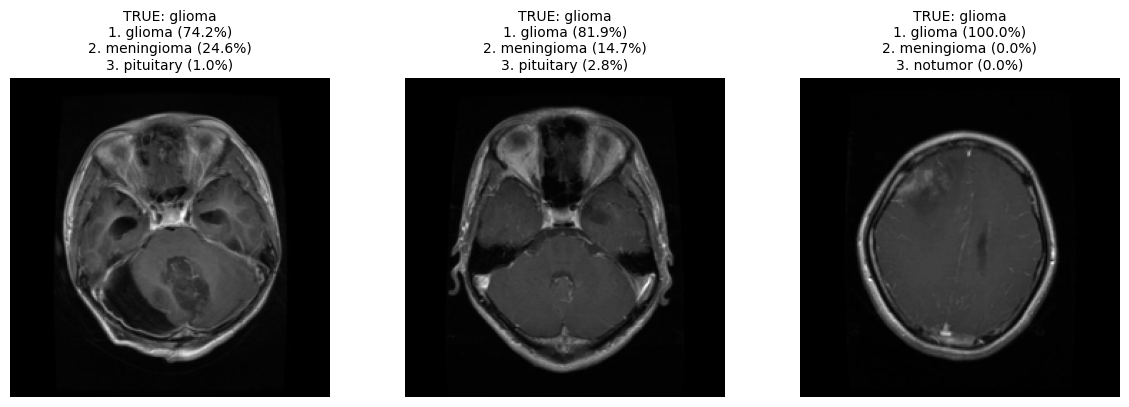


Incorrect Predictions:



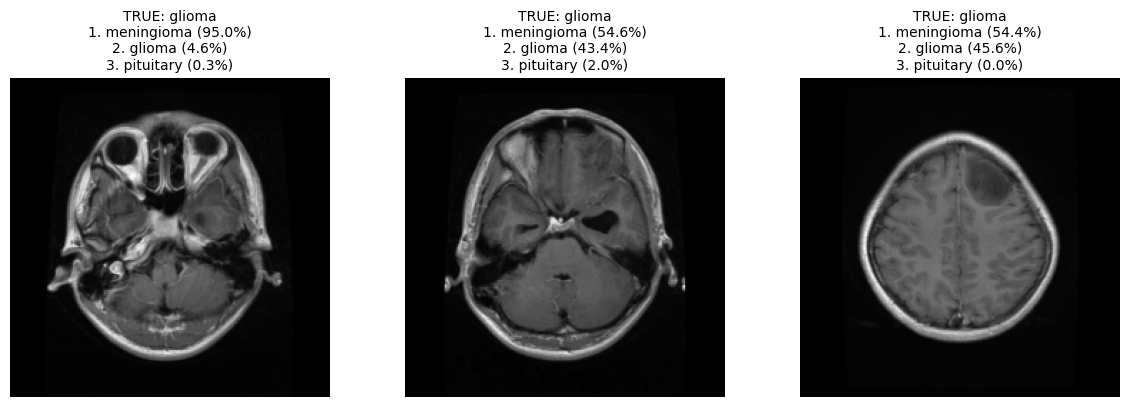

In [44]:
plot_model_predictions_topk(model, test_loader, num_samples=3, top_k=3)
